# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier with Deep Learning

---
## Step 0: Load The Data

In [1]:
import pickle

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [51]:
import pandas as pd
sign_type_names = pd.read_csv('signnames.csv')['SignName'].values

n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print('')
print('Sign type frequencies in training set:')
for i in range(43):
    print('  ' + str(list(y_train).count(i)) + ' - ' + str(i) + ' - ' + sign_type_names[i])

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43

Sign type frequencies in training set:
  180 - 0 - Speed limit (20km/h)
  1980 - 1 - Speed limit (30km/h)
  2010 - 2 - Speed limit (50km/h)
  1260 - 3 - Speed limit (60km/h)
  1770 - 4 - Speed limit (70km/h)
  1650 - 5 - Speed limit (80km/h)
  360 - 6 - End of speed limit (80km/h)
  1290 - 7 - Speed limit (100km/h)
  1260 - 8 - Speed limit (120km/h)
  1320 - 9 - No passing
  1800 - 10 - No passing for vehicles over 3.5 metric tons
  1170 - 11 - Right-of-way at the next intersection
  1890 - 12 - Priority road
  1920 - 13 - Yield
  690 - 14 - Stop
  540 - 15 - No vehicles
  360 - 16 - Vehicles over 3.5 metric tons prohibited
  990 - 17 - No entry
  1080 - 18 - General caution
  180 - 19 - Dangerous curve to the left
  300 - 20 - Dangerous curve to the right
  270 - 21 - Double curve
  330 - 22 - Bumpy road
  450 - 23 - Slipper

### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

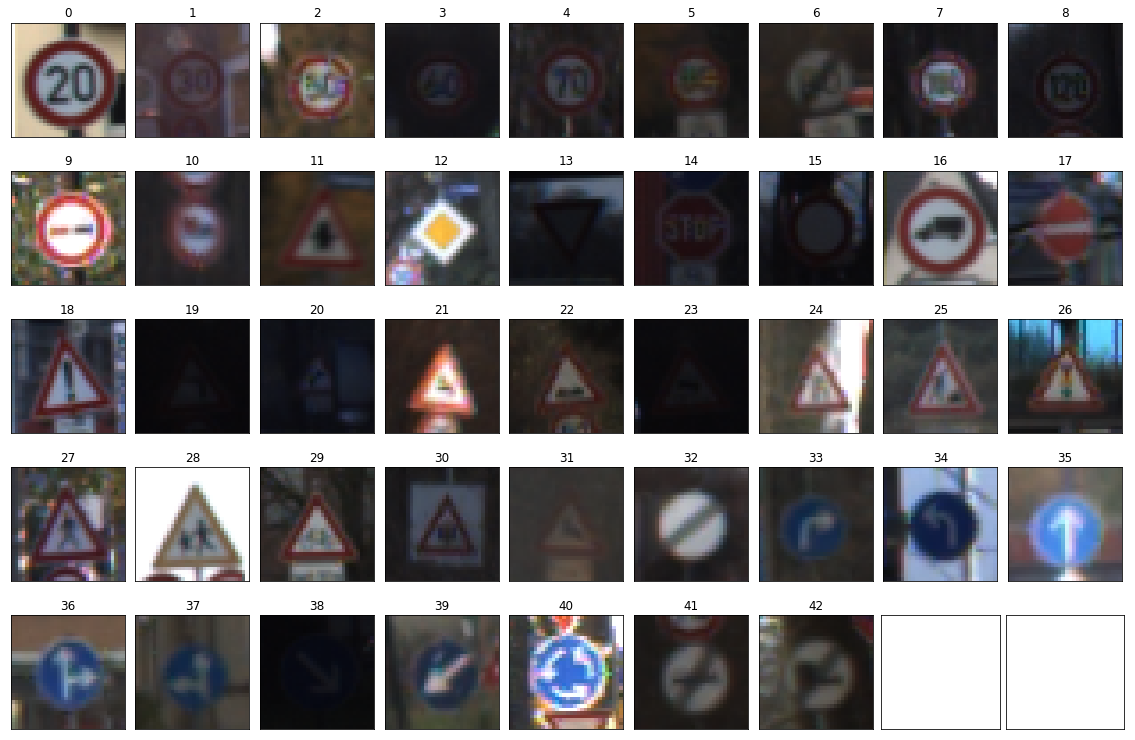

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

fig, axes = plt.subplots(5, 9, figsize=(20, 13),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, sign_id in zip(axes.flat, range(43)):
    sign_idx = np.where(y_train == sign_id)[0][0]
    ax.imshow(X_train[sign_idx])
    ax.set_title(str(sign_id))

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

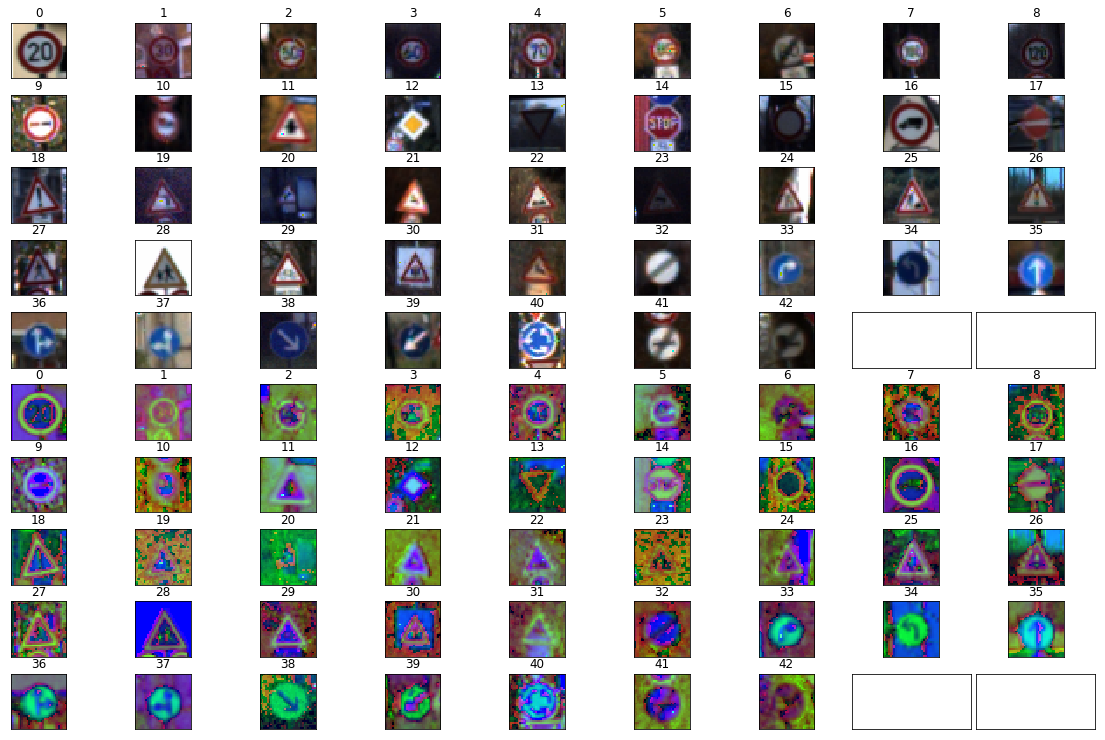

In [4]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import cv2

def white_correct_image(image):
    # normalize within usual (0, 255) image range
    low = np.amin(image)
    high = np.amax(image)
    image = np.floor((image - low + 1.5) * 253.0 / (high - low)).astype(np.uint8)
    return image

def preprocess_image(image):
    # normalize within usual (0, 255) image range
    image = white_correct_image(image)
    # convert to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # combine normalized and HSV into a 6-channel representation
    image = cv2.merge(cv2.split(image) + cv2.split(image_hsv))
    # normalize to (-0.5, 0.5) range
    image = (image / 255) - 0.5
    return image

# Show that HSV channels added in preprocess_image clarify some of the signs, especially those that are dimly lit.
fig, axes = plt.subplots(10, 9, figsize=(20, 13),
                         subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
for ax, sign_id in zip(axes.flat, range(43)):
    sign_idx = np.where(y_train == sign_id)[0][0]
    ax.imshow(white_correct_image(X_train[sign_idx]))
    ax.set_title(str(sign_id))
for ax, sign_id in zip(axes.flat[45:], range(43)):
    sign_idx = np.where(y_train == sign_id)[0][0]
    ax.imshow(cv2.cvtColor(white_correct_image(X_train[sign_idx]), cv2.COLOR_BGR2HSV))
    ax.set_title(str(sign_id))

plt.show()

### Model Architecture

In [55]:
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

def compile_model(model):
  """Would be part of create_model, except that same settings
     also need to be applied when loading model from file."""
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model = Sequential()
# Convolution2D(output_depth, convolution height, convolution_width, ...)
model.add(Convolution2D(30, 5, 5, border_mode='valid', input_shape=(32,32,6))) # -> (28,28,30)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(50, 5, 5, border_mode='valid')) # -> (24,24,50)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(60, 5, 5, border_mode='valid')) # -> (20,20,60)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(80, 5, 5, border_mode='valid')) # -> (16,16,80)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(100, 3, 3, border_mode='valid')) # -> (14,14,100)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(110, 3, 3, border_mode='valid')) # -> (12,12,110)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(130, 3, 3, border_mode='valid')) # -> (10,10,130)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(130, 3, 3, border_mode='valid')) # -> (8,8,130)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(130, 3, 3, border_mode='valid')) # -> (6,6,130)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(130, 3, 3, border_mode='valid')) # -> (4,4,130)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Convolution2D(130, 3, 3, border_mode='valid')) # -> (2,2,130)
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Flatten()) # 2x2x130 -> 520
model.add(Dense(130, W_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(120, W_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(120, W_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax', W_regularizer=l2(0.01)))
compile_model(model)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [58]:
import random

class sample_generator(object):
    def __init__(self, X, y, batch_size=100, normalize_frequencies=False):
        self.ordering = list(range(X.shape[0]))
        if normalize_frequencies:
            indices_by_sign_type = []
            max_examples_for_type = 0
            for sign_type in range(43):
                indices_for_this_sign_type = list(filter((lambda i: y[i] == sign_type), self.ordering))
                num_examples = len(indices_for_this_sign_type)
                if num_examples > max_examples_for_type:
                    max_examples_for_type = num_examples
                indices_by_sign_type.append(indices_for_this_sign_type)
            self.ordering = []
            for sign_type in range(43):
                examples_for_this_type = indices_by_sign_type[sign_type]
                num_examples = len(examples_for_this_type)
                multiplier = int((max_examples_for_type / num_examples) + 0.5)
                self.ordering = self.ordering + (examples_for_this_type * multiplier)
        random.shuffle(self.ordering)
        self.X = X
        self.y = y
        self.batch_size = batch_size
    def __iter__(self):
        return self
    def __next__(self):
        return self.next()
    def next(self):
        batch_indices = self.ordering[:self.batch_size]
        self.ordering = self.ordering[self.batch_size:] + self.ordering[:self.batch_size]
        batch_X = []
        batch_y = []
        for i in batch_indices:
            batch_X.append(preprocess_image(self.X[i]))
            one_hot = np.zeros(43)
            one_hot[self.y[i]] = 1.0
            batch_y.append(one_hot)
        return (np.stack(batch_X), np.stack(batch_y))

In [59]:
history = model.fit_generator(sample_generator(X_train, y_train, batch_size=500, normalize_frequencies=True),
                              samples_per_epoch=10000, nb_epoch=200,
                              validation_data=sample_generator(X_valid, y_valid, batch_size=400, normalize_frequencies=True),
                              nb_val_samples=400)

Epoch 1/200
10000/10000 [==============================] - 7s - loss: 9.1026 - acc: 0.0226 - val_loss: 8.1603 - val_acc: 0.0150

### Save the Model

In [60]:
# Run this cell after training to save progress (retraining can take a long time)
with open('model.json', 'w') as arch_file:
  arch_file.write(model.to_json())
model.save_weights('model.h5')

### Load the Model

In [7]:
# Run this cell to restore a saved model rather than retraining
from keras.models import model_from_json
with open('model.json', 'r') as arch_file:
  model = model_from_json(arch_file.read())
  compile_model(model)
  model.load_weights('model.h5')

### Evaluate the Model

In [61]:
# Evaluate with training data. Returns [cross_entropy, accuracy]
model.evaluate_generator(sample_generator(X_train, y_train, batch_size=500),34500)

[0.35723190074381622, 0.9956812314365221]

In [62]:
# Evaluate with validation data. Returns [cross_entropy, accuracy]
model.evaluate_generator(sample_generator(X_valid, y_valid, batch_size=400),4400)

[0.39653526382012799, 0.98704540729522705]

In [63]:
# Evaluate with test data. Returns [cross_entropy, accuracy]
model.evaluate_generator(sample_generator(X_test, y_test, batch_size=500),12500)

[0.53902235627174377, 0.95912003278732305]

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

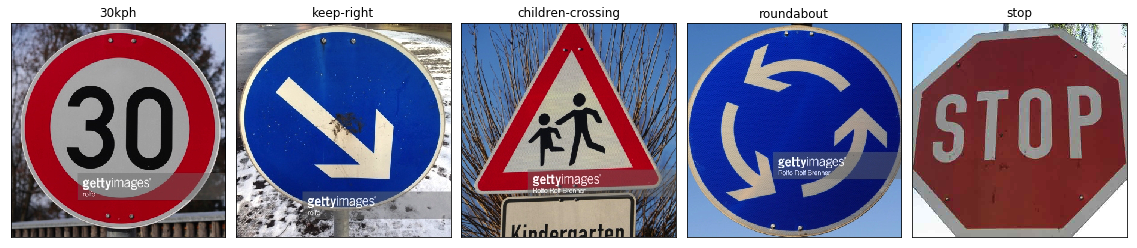

In [64]:
### Load the images and plot them here.
import matplotlib.image as mpimg
%matplotlib inline

downloaded_file_names = ['30kph','keep-right','children-crossing','roundabout','stop']
downloaded_images = []
for fname in downloaded_file_names:
    downloaded_images.append(mpimg.imread('examples/' + fname + '.jpeg'))
    
fig, axes = plt.subplots(1, 5, figsize=(20, 13),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.05)

for ax, i in zip(axes.flat, range(5)):
    ax.imshow(downloaded_images[i])
    ax.set_title(downloaded_file_names[i])

plt.show()

### Predict the Sign Type for Each Image

In [65]:
### Run the predictions here and use the model to output the prediction for each image.
preprocessed_images = []
predictions = []
for img in downloaded_images:
    img = cv2.resize(img, (32,32))
    img = preprocess_image(img)
    preprocessed_images.append(img)
    prediction = model.predict(img[None,:,:,:], batch_size=1)[0]
    labelled_prediction = [{'label': sign_type_names[i], 'odds': odds} for i,odds in enumerate(prediction)]
    top5 = list(reversed(sorted(labelled_prediction, key=lambda row: row['odds'])))[:5]
    predictions.append(top5)
    
print('-- Predictions --')
for fname,pred in zip(downloaded_file_names, predictions):
    print('')
    print('  '+fname+':')
    for p in pred:
        print(('%9.2f' % (p['odds'] * 100)) + '%  '+p['label'])

-- Predictions --

  30kph:
    94.96%  Speed limit (30km/h)
     0.90%  Go straight or left
     0.71%  Speed limit (20km/h)
     0.68%  Speed limit (80km/h)
     0.47%  Speed limit (50km/h)

  keep-right:
    95.18%  Keep right
     0.67%  Turn left ahead
     0.61%  End of no passing
     0.57%  Dangerous curve to the right
     0.50%  Go straight or right

  children-crossing:
    83.63%  Children crossing
     4.31%  Bicycles crossing
     2.42%  Speed limit (60km/h)
     1.94%  Speed limit (120km/h)
     1.18%  Right-of-way at the next intersection

  roundabout:
    95.58%  Roundabout mandatory
     0.47%  Priority road
     0.46%  Keep left
     0.46%  Speed limit (100km/h)
     0.42%  End of no passing by vehicles over 3.5 metric tons

  stop:
    69.15%  Stop
     8.44%  Bicycles crossing
     6.19%  Yield
     2.58%  Speed limit (80km/h)
     1.82%  Dangerous curve to the right


### Analyze Performance

The model achieved 100% accuracy on these five images by predicting the correct sign type for all five images.

The model was very confident (95%) in its prediction for three of the signs: speed limit 30km/h, keep right, and roundabout mandatory. It had lower confidence in children crossing (84%) and stop (69%).

The children crossing sign had a runner up prediction of bicycles crossing (4%) which is a similar sign. The stop sign also had a runner up prediction of bicycles crossing (8%) which really doesn't make sense.

While the model got all 5 signs correct, I'm curious why it expressed so little confidence in the stop sign, which was a very clear image. I'm also curious what aspect of bicycles crossing made it an alternative candidate for a stop sign.

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 